In [3]:
import pandas as pd
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
import datetime as dt
import scipy as sp

In [4]:
dfTUS2 = pd.read_csv('UPR_TUS2.csv')
dfTUS4 = pd.read_csv('UPR_TUS4.csv')
dfTUS5 = pd.read_csv('UPR_TUS5.csv')

In [5]:
dfTUS2['id'] = dfTUS2.groupby(['FSU','District','Sample HHID','PersonID']).ngroup()
dfTUS2 = dfTUS2.set_index('id')

dfTUS4['id'] = dfTUS4.groupby(['FSU','District','Sample HHID','PersonID']).ngroup()
dfTUS4 = dfTUS4.set_index('id')

dfTUS5['id'] = dfTUS5.groupby(['FSU','District','Sample HHID','PersonID']).ngroup()
dfTUS5 = dfTUS5.set_index('id')

In [6]:
TUS_merged = pd.merge(dfTUS2, dfTUS4, on = 'id')

In [7]:
TUS_full = pd.merge(dfTUS5, TUS_merged, left_index=True, right_index = True)
TUS_full.index.nunique()

39654

In [8]:
col = ['FSU', 'Sector', 'State', 'District', 'Stratum',
       'Sub-stratum', 'Sample HHID', 'PersonID',
       'Paid-unpaid', 'Type of enterprise', 'NSC', 'Multiplier',
       'Unnamed: 0_x', 'FSU_x', 'Sector_x', 'State_x', 'District_x',
       'Stratum_x', 'Sub-stratum_x', 'Sample HHID_x', 'PersonID_x',
       'RelationToHead', 'Gender', 'Age', 'MaritalStatus', 'Education',
       'PrincipleActivity', 'Industry of work', 'NSC_x', 'Multiplier_x',
       'Unnamed: 0_y', 'FSU_y', 'Sector_y', 'State_y', 'District_y',
       'Stratum_y', 'Sub-stratum_y', 'Sample HHID_y', 'PersonID_y',
       'Day of the week', 'Type of the day', 'Response code', 'NSC_y',
       'Unnamed: 0']
    
TUS_State = TUS_full.drop(columns = col, axis=1)
TUS_State = TUS_State.reset_index()
del(TUS_full)

In [9]:
conditions = [(TUS_State["Activity group"] == 12), 
              (TUS_State["Activity group"] == 31),
              (TUS_State["Activity group"] == 32), 
              (TUS_State["Activity group"] == 34),
              (TUS_State["Activity group"] == 62),
              (TUS_State["Activity group"] == 91),
              (TUS_State["Activity group"] == 92),
              (TUS_State["Activity group"] == 93),
              (TUS_State["Activity code"] == 842),               
              (TUS_State["Activity code"] == 843)]
values = [1,2,3,4,5,10,8,9,6,7]

TUS_State['Activity group'] = np.select(conditions, values)
TUS_State["Activity group"].unique()

array([10,  9,  3,  8,  0,  2,  1,  5,  4,  6,  7])

In [10]:
TUS_State = TUS_State.loc[(TUS_State[["Activity group"]] != 0).all(axis=1)]
TUS_State["Activity group"].unique()

array([10,  9,  3,  8,  2,  1,  5,  4,  6,  7])

In [11]:
TUS_State["Start_time"] = pd.to_datetime(TUS_State['Time from'], format="%H:%M").dt.time
TUS_State["End_time"] = pd.to_datetime(TUS_State['Time to'], format="%H:%M").dt.time

In [12]:
TUS_State = TUS_State[TUS_State['Where']==1]

In [13]:
times = np.arange(0,24,0.5)
nt = times.shape[0]
state_min = 1
state_max = 10
nstate_tot = state_max-state_min+1
sleeping_state = 10

start_time_matrix = []

for j in range(nstate_tot):
    start_time_matrix.append(np.zeros(nt))
    
no_arr = np.array([])
duration_matrix_notime = []
for k in range(nstate_tot):
    duration_matrix_notime.append(no_arr)

no_arr = np.array([])
duration_matrix_notime_weights = []
for k in range(nstate_tot):
    duration_matrix_notime_weights.append(no_arr)
    
duration_matrix_timezones = []
no_arr = np.array([])
for j in range(4):
    ar1 = []
    for k in range(nstate_tot):
        ar1.append(no_arr)
    duration_matrix_timezones.append(ar1)


duration_matrix_timezones_weights = []
no_arr = np.array([])
for j in range(4):
    ar1 = []
    for k in range(nstate_tot):
        ar1.append(no_arr)
    duration_matrix_timezones_weights.append(ar1)
    
ids = np.sort(TUS_State['id'].unique())
time_zones = [4,10,16,20]
def get_timezone(t):
    tzone = 3
    if(t.hour >= time_zones[0] and  t.hour <= time_zones[1]):
        tzone = 0
    if(t.hour > time_zones[1] and  t.hour <= time_zones[2]):
        tzone = 1
    if(t.hour > time_zones[2] and  t.hour <= time_zones[3]):
        tzone = 2
    if(t.hour > time_zones[3]):
        tzone = 3 
    return tzone

for idi in ids:
    TUS_State_temp0 = TUS_State[TUS_State['id'] == idi].copy()
    activites = TUS_State_temp0['Activity group'].unique()
    for activity in activites:
        TUS_State_temp = TUS_State_temp0[TUS_State_temp0['Activity group'] == activity].copy()
        nentries = TUS_State_temp.index.nunique()
        if(nentries > 0 and activity != sleeping_state):
                time_stampm1 = TUS_State_temp['Start_time'].iloc[0]
                time_stampm2 = TUS_State_temp['End_time'].iloc[0]
                
                current_duration =  (time_stampm2.hour - time_stampm1.hour) + 0.5*(time_stampm2.minute-time_stampm1.minute)/30
                timepos = np.where(times == (time_stampm1.hour+0.5*time_stampm1.minute/30))[0][0]
                start_time_matrix[activity-1][timepos] += 1
                if(nentries == 1):
                    arr_temp = np.concatenate((duration_matrix_notime[activity-1],np.array([current_duration])))
                    duration_matrix_notime[activity-1] = arr_temp    
                    tzone = get_timezone(time_stampm1)           
                    arr_temp = np.concatenate((duration_matrix_timezones[tzone][activity-1],np.array([current_duration])))
                    duration_matrix_timezones[tzone][activity-1] = arr_temp                    
                else:
                    for i in np.arange(1,nentries,1):
                        time_stamp1 = TUS_State_temp['Start_time'].iloc[i]
                        time_stamp2 = TUS_State_temp['End_time'].iloc[i]
                        time_change_duration = (time_stamp2.hour - time_stamp1.hour) + 0.5*(time_stamp2.minute-time_stamp1.minute)/30   
                        if(time_stamp1 == time_stampm2 and i != nentries-1):
                            current_duration = current_duration + time_change_duration
                            time_stampm1 = time_stamp1
                            time_stampm2 = time_stamp2
                        else:
                            arr_temp = np.concatenate((duration_matrix_notime[activity-1],np.array([current_duration])))
                            duration_matrix_notime[activity-1] = arr_temp
                            tzone = get_timezone(time_stampm1)    
                            arr_temp = np.concatenate((duration_matrix_timezones[tzone][activity-1],np.array([current_duration])))
                            duration_matrix_timezones[tzone][activity-1] = arr_temp
                            time_stampm1 = time_stamp1
                            time_stampm2 = time_stamp2
                            current_duration =  (time_stampm2.hour - time_stampm1.hour) + 0.5*(time_stampm2.minute-time_stampm1.minute)/30
                            timepos = np.where(times == (time_stampm1.hour+0.5*time_stampm1.minute/30))[0][0]
                            start_time_matrix[activity-1][timepos] += 1

tot_ids = np.shape(ids)[0]        
for i in range(nstate_tot):
    if(i != (sleeping_state-1)):
        start_time_matrix[i] = start_time_matrix[i]/tot_ids

In [14]:
nsleeping_entries = 0
for idi in ids:
    TUS_State_temp0 = TUS_State[TUS_State['id'] == idi].copy()
    activity = sleeping_state
    TUS_State_temp = TUS_State_temp0[TUS_State_temp0['Activity group'] == activity].copy()
    nentries = TUS_State_temp.index.nunique()
    if(nentries > 1):
        nsleeping_entries += 1 
        
nsleeping_entries/tot_ids

0.9814814814814815

In [15]:
for idi in ids:
    TUS_State_temp0 = TUS_State[TUS_State['id'] == idi].copy()
    activity = sleeping_state
    TUS_State_temp = TUS_State_temp0[TUS_State_temp0['Activity group'] == activity].copy()
    nentries = TUS_State_temp.index.nunique()
    if(nentries == 2):
        time_stamp1 = TUS_State_temp['End_time'].iloc[0]
        time_stamp2 = TUS_State_temp['Start_time'].iloc[1]
        if(time_stamp2.hour > 20):
            current_duration = 24 - time_stamp2.hour + 0.5*(time_stamp2.minute)/30  + time_stamp1.hour + 0.5*(time_stamp1.minute)/30
            arr_temp = np.concatenate((duration_matrix_notime[activity-1],np.array([current_duration])))
            duration_matrix_notime[activity-1] = arr_temp  
            arr_temp = np.concatenate((duration_matrix_timezones[3][activity-1],np.array([current_duration])))
            duration_matrix_timezones[3][activity-1] = arr_temp
            timepos = np.where(times == (time_stamp2.hour+0.5*time_stamp2.minute/30))[0][0]
            start_time_matrix[activity-1][timepos] += 1
            
    elif(nentries == 3):
        time_stamp1 = TUS_State_temp['End_time'].iloc[0]
        time_stamp2 = TUS_State_temp['Start_time'].iloc[2]
        if(time_stamp2.hour < 16):
            current_duration = time_stamp1.hour + 0.5*(time_stamp1.minute)/30
        else:
            current_duration = 24 - time_stamp2.hour + 0.5*(time_stamp2.minute)/30  + time_stamp1.hour + 0.5*(time_stamp1.minute)/30
        arr_temp = np.concatenate((duration_matrix_notime[activity-1],np.array([current_duration])))
        duration_matrix_notime[activity-1] = arr_temp       
        arr_temp = np.concatenate((duration_matrix_timezones[3][activity-1],np.array([current_duration])))
        duration_matrix_timezones[3][activity-1] = arr_temp
        timepos = np.where(times == (time_stamp2.hour+0.5*time_stamp2.minute/30))[0][0]
        start_time_matrix[activity-1][timepos] += 1 
        #####
        time_stamp1 = TUS_State_temp['Start_time'].iloc[1]
        time_stamp2 = TUS_State_temp['End_time'].iloc[1]
        if(time_stamp1.hour >= 4 and  time_stamp1.hour <= 10):
            tzone = 0
        if(time_stamp1.hour > 10 and  time_stamp1.hour <= 16):
            tzone = 1
        if(time_stamp1.hour > 16 and  time_stamp1.hour <= 20):
            tzone = 2
        if(time_stamp1.hour > 20):
            tzone = 3   
        current_duration = time_stamp2.hour + 0.5*(time_stamp2.minute)/30 - time_stamp1.hour - 0.5*(time_stamp1.minute)/30
        if(current_duration > 0):
            arr_temp = np.concatenate((duration_matrix_notime[activity-1],np.array([current_duration])))
            duration_matrix_notime[activity-1] = arr_temp  
            arr_temp = np.concatenate((duration_matrix_timezones[tzone][activity-1],np.array([current_duration])))
            duration_matrix_timezones[tzone][activity-1] = arr_temp
            timepos = np.where(times == (time_stamp2.hour+0.5*time_stamp2.minute/30))[0][0]
            start_time_matrix[activity-1][timepos] += 1
    
start_time_matrix[sleeping_state-1] = start_time_matrix[sleeping_state-1]/tot_ids

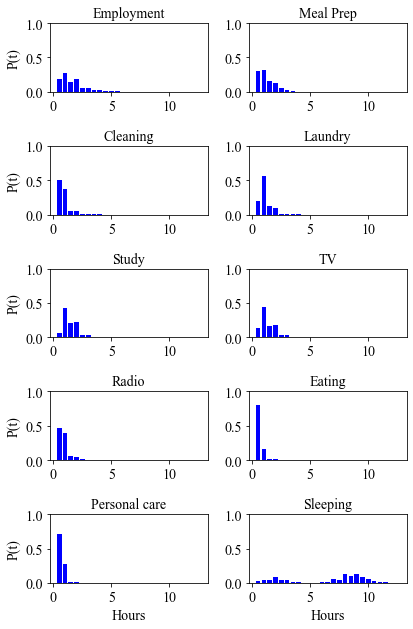

In [51]:
plt.rcParams['font.family'] = 'Times New Roman'

x_axes_dims = [5, 2]
fig, axes = plt.subplots(nrows=x_axes_dims[0], ncols=x_axes_dims[1], figsize=(6, 9))

activities_names = ['Employment', 'Meal Prep', 'Cleaning', 'Laundry', 'Study', 'TV', 'Radio', 'Eating', 'Personal care', 'Sleeping']
binarray = np.arange(0.5, 13.5, 0.5)
k = 0

for i in range(x_axes_dims[0]):
    for j in range(x_axes_dims[1]):
        n, bins = np.histogram(duration_matrix_notime[k], bins=binarray, density=True)
        axes[i, j].bar(bins[:-1], 0.5 * n, color = 'blue', width=0.4)
        axes[i, j].set_title(activities_names[k], fontsize=14)
        axes[i, j].set_ylim([0, 1])
        axes[i, j].tick_params(axis='both', labelsize=14)
        k += 1
axes[4, 0].set_xlabel('Hours', fontsize=14)
axes[4, 1].set_xlabel('Hours', fontsize=14)
axes[0, 0].set_ylabel('P(t)', fontsize=14)
axes[1, 0].set_ylabel('P(t)', fontsize=14)
axes[2, 0].set_ylabel('P(t)', fontsize=14)
axes[3, 0].set_ylabel('P(t)', fontsize=14)
axes[4, 0].set_ylabel('P(t)', fontsize=14)

plt.tight_layout()
plt.savefig('UP_load_duration_probabilities.png')
plt.show()


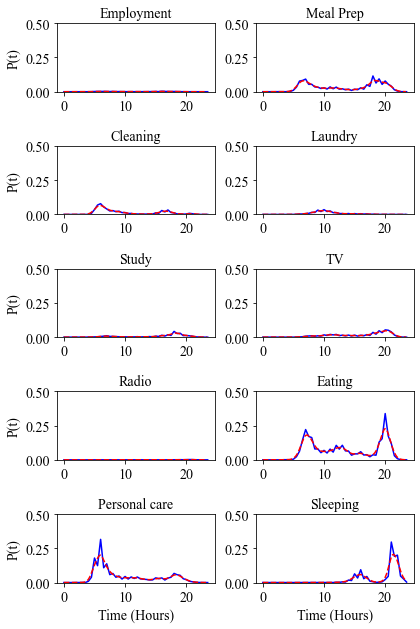

In [50]:
time_hr = [np.round(t) for t in times]
axes_dims = [5,2]
fig, axs = plt.subplots(axes_dims[0], axes_dims[1], figsize = (6,9))
k = 0
times_range = np.arange(0,24,0.5)
times_range_int = np.arange(0,23.5,0.1)
start_times_interpolate_fn = [0 for i in range(10)]
for i in range(axes_dims[0]):
    for j in range(axes_dims[1]):
        stgs = scipy.ndimage.gaussian_filter1d(start_time_matrix[k],1) # gaussian smoothing filter 1d - weighted average of records
        start_times_interpolate_fn[k] = scipy.interpolate.interp1d(times_range,stgs,kind = "cubic") # cubic interpolation of smoothened data 
        axs[i, j].plot(times_range,start_time_matrix[k], '-b')
        axs[i, j].plot(times_range_int,start_times_interpolate_fn[k](times_range_int),'--r')
        axs[i, j].set_ylim([0, 0.5])
        axs[i, j].tick_params(axis='both', labelsize=14)
        axs[i, j].set_title(activities_names[k], fontsize=14)
        k = k+1
axs[4, 0].set_xlabel('Time (Hours)', fontsize=14)
axs[4, 1].set_xlabel('Time (Hours)', fontsize=14)
axs[0, 0].set_ylabel('P(t)', fontsize=14)
axs[1, 0].set_ylabel('P(t)', fontsize=14)
axs[2, 0].set_ylabel('P(t)', fontsize=14)
axs[3, 0].set_ylabel('P(t)', fontsize=14)
axs[4, 0].set_ylabel('P(t)', fontsize=14)    
plt.tight_layout()
plt.savefig('UP_start time probabilities.png', dpi=300)
plt.show()

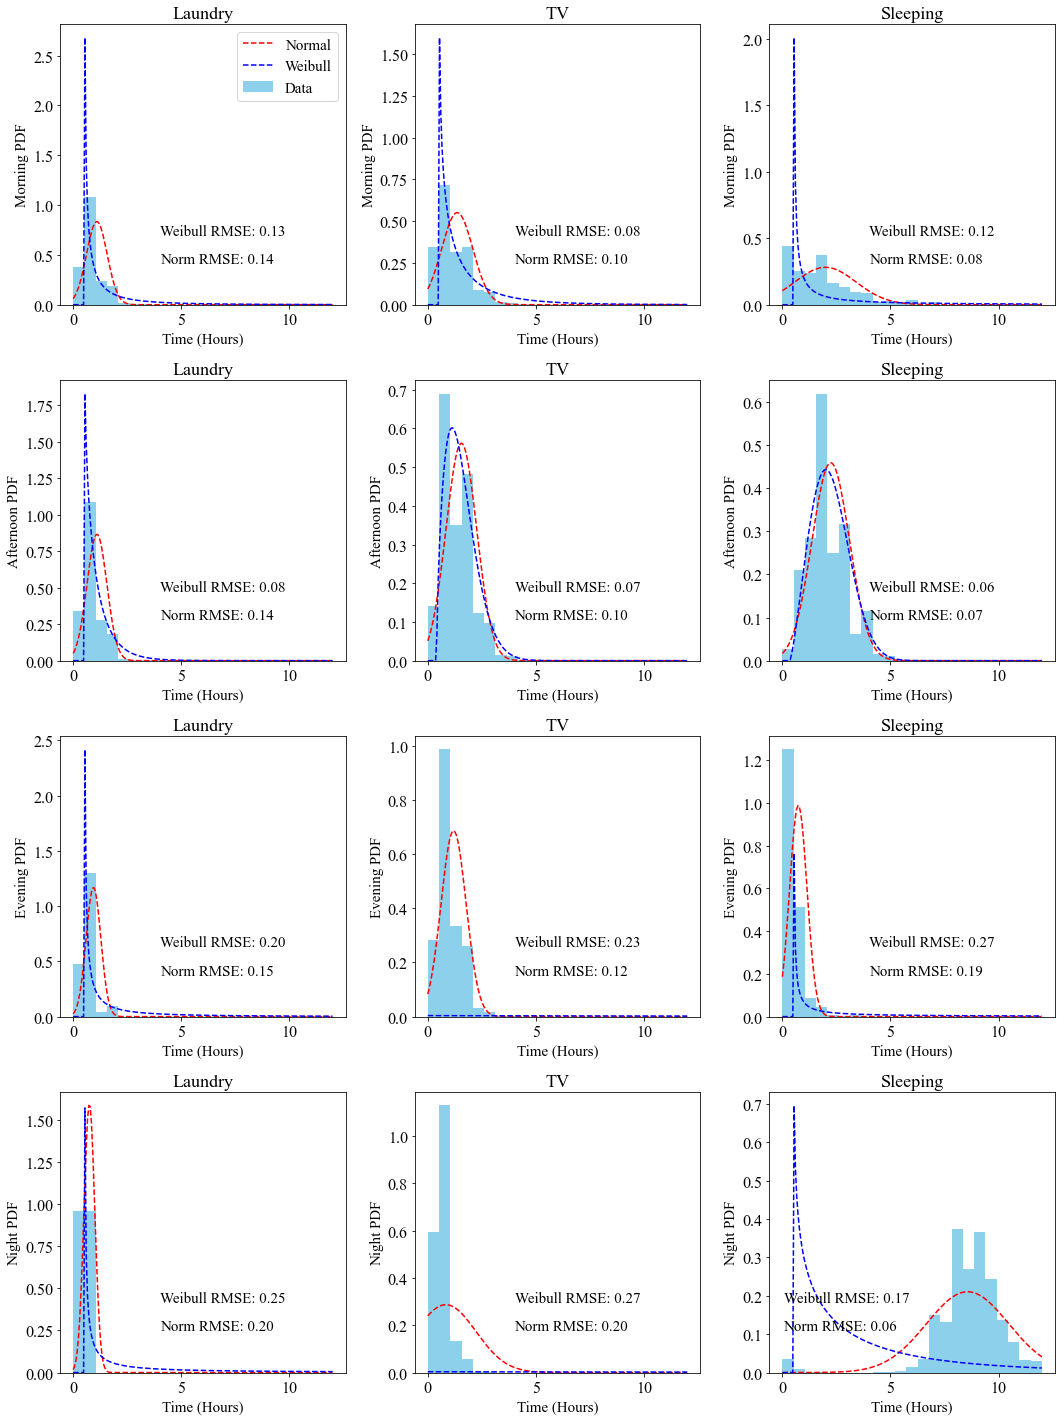

In [55]:

timezone_names=['Morning','Afternoon','Evening','Night']

def root_mean_squared_error(observed, expected):
    return np.sqrt(np.mean((observed - expected) ** 2))

def mean_absolute_error(observed, expected):
    return np.mean(np.abs(observed - expected))
plt.rcParams.update({'font.size': 15})
i_values = range(4)
j_values = [3, 5, 9]


fig, axes = plt.subplots(len(i_values), len(j_values), figsize=(15, 20))

binarray = np.linspace(0, 12, 24)

for i_idx, i in enumerate(i_values):
    for j_idx, j in enumerate(j_values):
        ax = axes[i_idx][j_idx]
        
        data = duration_matrix_timezones[i][j]
        hist, bin_edges = np.histogram(data, bins=binarray, density=True)
        bin_midpoints = (bin_edges[:-1] + bin_edges[1:]) / 2
        # Fit normal distribution
        norm_dist = scipy.stats.norm
        norm_params = norm_dist.fit(data)
        x_norm = np.linspace(0, 12, 200)
        norm_pdf = norm_dist.pdf(x_norm, *norm_params)
        
        # Fit Weibull distribution
        weibull_dist = scipy.stats.weibull_min
        weibull_params = weibull_dist.fit(data)
        x_weibull = np.linspace(0, 12, 200)
        weibull_pdf = weibull_dist.pdf(x_weibull, *weibull_params)
        
       
        ax.hist(data, bins=binarray, density=True, alpha=0.95, color='skyblue', label='Data')
        ax.plot(x_norm, norm_pdf, 'r--', label='Normal')
        ax.plot(x_weibull, weibull_pdf, 'b--', label='Weibull')
        
        # Add RMSE t
        norm_rmse = root_mean_squared_error(hist, norm_dist.pdf(bin_midpoints, *norm_params))


        weibull_rmse = root_mean_squared_error(hist, weibull_dist.pdf(bin_midpoints, *weibull_params))

        if(j == 9 and i ==3 ):
            ax.text(0.05, 0.15, f"Norm RMSE: {norm_rmse:.2f}", transform=ax.transAxes)

            ax.text(0.05, 0.25, f"Weibull RMSE: {weibull_rmse:.2f}", transform=ax.transAxes)
  
        else:
            ax.text(0.35, 0.15, f"Norm RMSE: {norm_rmse:.2f}", transform=ax.transAxes)
  
            ax.text(0.35, 0.25, f"Weibull RMSE: {weibull_rmse:.2f}", transform=ax.transAxes)
    
        
       
        ax.set_title(activities_names[j])
        ax.set_xlabel("Time (Hours)")
        ax.set_ylabel(timezone_names[i]+' PDF')
        ax.tick_params(axis='both',labelsize=16)
       
        if i_idx == 0 and j_idx == 0:
            ax.legend()

plt.tight_layout()
plt.savefig('UP_laundary_tv_sleeping_fits.png', dpi=300)
plt.show()


C:\Users\2456\anaconda3_1\lib\site-packages\numpy\lib\histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


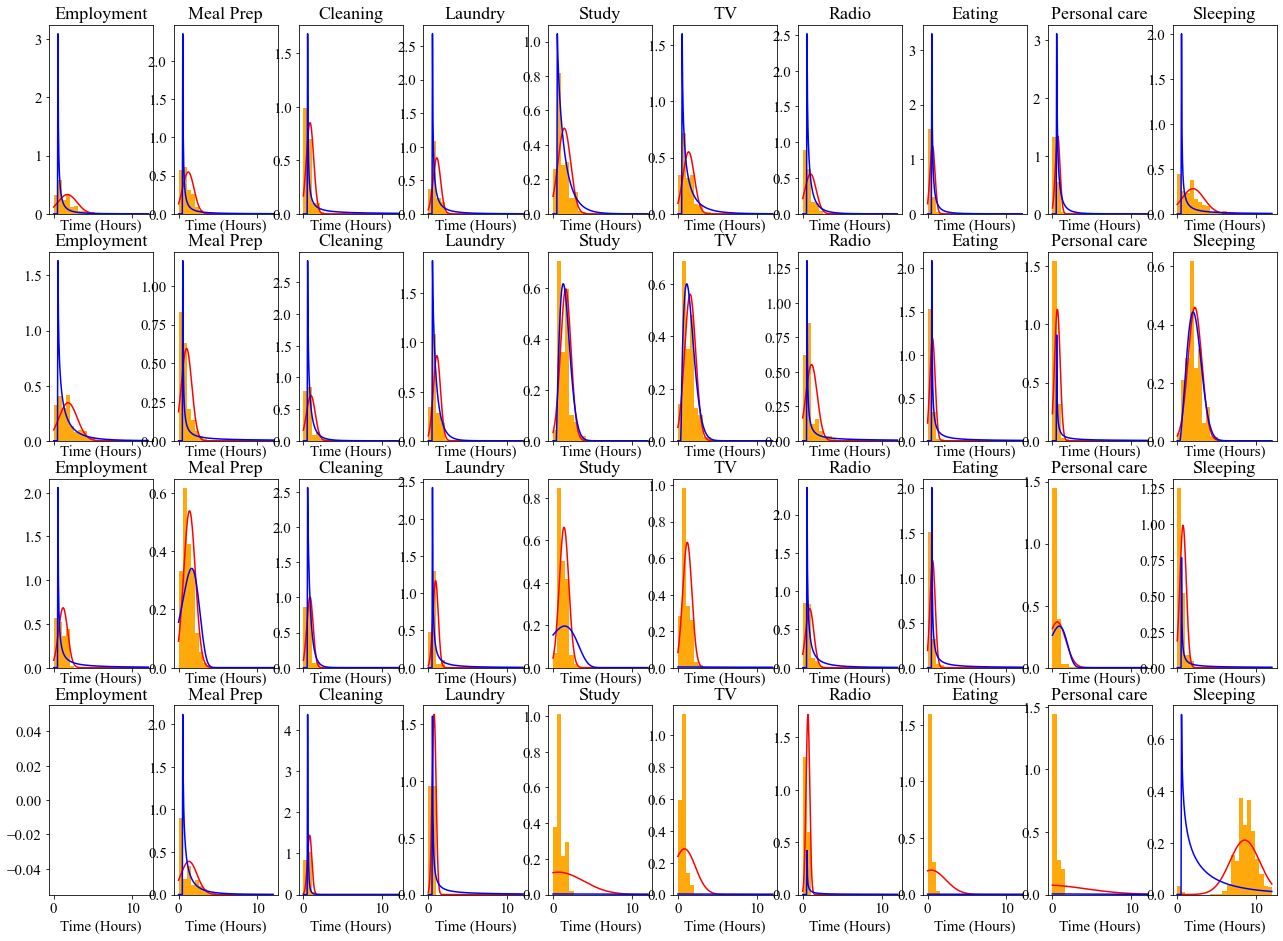

In [28]:
def root_mean_squared_error(observed, expected):
    return np.sqrt(np.mean((observed - expected) ** 2))

def mean_absolute_error(observed, expected):
    return np.mean(np.abs(observed - expected))

timezone_names=['Morning','Afternoon','Evening','Night']

duration_normal_parameters = [[0 for i in range(10)] for j in range(4)]
duration_weibull_parameters = [[0 for i in range(10)] for j in range(4)]

i_values = range(4)
j_values = range(10)


fig, axes = plt.subplots(len(i_values), len(j_values), figsize=(22, 16), sharex = True)

binarray = np.linspace(0, 12, 24)

for i_idx, i in enumerate(i_values):
    for j_idx, j in enumerate(j_values):
        ax = axes[i_idx][j_idx]
        
        data = duration_matrix_timezones[i][j]
        if np.size(data) > 0:
            hist, bin_edges = np.histogram(data, bins=binarray, density=True)
            bin_midpoints = (bin_edges[:-1] + bin_edges[1:]) / 2
            
            
            # Fit normal distribution
            norm_dist = scipy.stats.norm
            norm_params = norm_dist.fit(data)
            x_norm = np.linspace(0, 12, 200)
            norm_pdf = norm_dist.pdf(x_norm, *norm_params)
            duration_normal_parameters[i][j] = norm_params
            # Fit Weibull distribution
            weibull_dist = scipy.stats.weibull_min
            weibull_params = weibull_dist.fit(data)
            x_weibull = np.linspace(0, 12, 200)
            weibull_pdf = weibull_dist.pdf(x_weibull, *weibull_params)
            duration_weibull_parameters[i][j] = weibull_params
            
            
            # Histogram with fitted distribution 
            ax.hist(data, bins=binarray, density=True, alpha=0.95, color='orange', label='Data')
            ax.plot(x_norm, norm_pdf, 'r-', label='Normal')
            ax.plot(x_weibull, weibull_pdf, 'b-', label='Weibull')

            # RMSE text
            norm_rmse = root_mean_squared_error(hist, norm_dist.pdf(bin_midpoints, *norm_params))
            weibull_rmse = root_mean_squared_error(hist, weibull_dist.pdf(bin_midpoints, *weibull_params))
   

            ax.set_title(activities_names[j])
            ax.set_xlabel("Time (Hours)")
        else:
            hist, bin_edges = np.histogram(data, bins=binarray, density=True)
            bin_midpoints = (bin_edges[:-1] + bin_edges[1:]) / 2
            ax.hist(data, bins=binarray, density=True, alpha=0.95, color='orange', label='Data')
            ax.set_title(activities_names[j])
            ax.set_xlabel("Time (Hours)")
            #ax.set_ylabel(timezone_names[i]+' pdf')

#             # Add legend only to the first plot
#             if i_idx == 0 and j_idx == 0:
#                 ax.legend()


In [42]:
import scipy.stats as stats

# Do it for TV 
k = 5

def interpolate_start_probability(act,t):
    return start_times_interpolate_fn[act](t)

def generate_load_profile(n_paths=10000, duration_pdfs=None, time_zones=None, time_step=0.5 , act = 5):
    
    all_paths = [0 for i in range(n_paths)]
    if duration_pdfs is None:
        duration_pdfs = [["gaussian"] * 4]  # Default to Gaussian for all time zones

    if time_zones is None:
        time_zones = [4, 10, 16, 20]  # Default time zone boundaries

    time_steps = int(24 / time_step)
    
    def get_duration_pdf(t, duration_pdfs, time_zones):
        for i, zone_boundary in enumerate(time_zones):
            if t < zone_boundary:
                zone_idx = i
                break
        else:
            zone_idx = len(time_zones) - 1

        pdf_name, params = duration_pdfs[zone_idx]
        if pdf_name == "gaussian":
            return stats.norm(*params)
        elif pdf_name == "weibull_min":
            return stats.weibull_min(*params)
        else:
            raise ValueError("Invalid duration_pdf")

    mean_path = np.zeros(time_steps)
    
    for i in range(n_paths):
        path = np.zeros(time_steps)
        t = 0
        while t < time_steps:
            start_prob = interpolate_start_probability(act,t * time_step)
            if(start_prob  >0 and start_prob < 1):
                startstate = np.random.choice([0,1], p=[1-start_prob, start_prob]) #Binomial sampling
            else:
                startstate = 0
            if startstate == 1:
                dist = get_duration_pdf(t * time_step, duration_pdfs, time_zones)
                duration = int(dist.rvs() / time_step) #Duration sampling 
                if duration < 0:
                    duration = 0
                path[t:t+duration] =  1
                t += duration
            else:
                t += 1
        mean_path += path
        all_paths[i] = path
    mean_path /= n_paths
    return mean_path,all_paths

    
# Define the duration parameters for each time zone
duration_pdfs = [
    ("weibull_min", duration_weibull_parameters[0][k]),
    ("weibull_min", duration_weibull_parameters[1][k]),
    ("gaussian", duration_normal_parameters[2][k]),
    ("gaussian", duration_normal_parameters[3][k])
]

# Specify the time zone 
time_zones = [4, 10, 16, 20] # 4am - 10am Morning 10am -16pm afternoon 16pm - 20pm evening, 20pm-4am night. 


time_step = 0.5 # 30min
n_paths = 10000
mean_path,all_paths = generate_load_profile(n_paths =n_paths, duration_pdfs=duration_pdfs, time_zones=time_zones, time_step=time_step, act = k)



In [43]:
time_steps = int(24 / time_step)
load_per_tv = 70
no_of_people = 100
no_of_subsampling = 5000
all_subsample_paths = [0 for i in range(no_of_subsampling)]
for j in range(no_of_subsampling):
    subsample_path_id = [np.random.choice(np.arange(0,n_paths,1)) for i in range(no_of_people)]
    xtotal = np.zeros(time_steps)
    for i in subsample_path_id:
        xtotal += all_paths[i]*load_per_tv
    all_subsample_paths[j] = xtotal
all_subsample_paths = np.array(all_subsample_paths)

mean_values = np.mean(all_subsample_paths, axis=0)    
std_values = np.std(all_subsample_paths, axis=0)
max_values = np.max(all_subsample_paths, axis=0)
min_values = np.min(all_subsample_paths, axis=0)

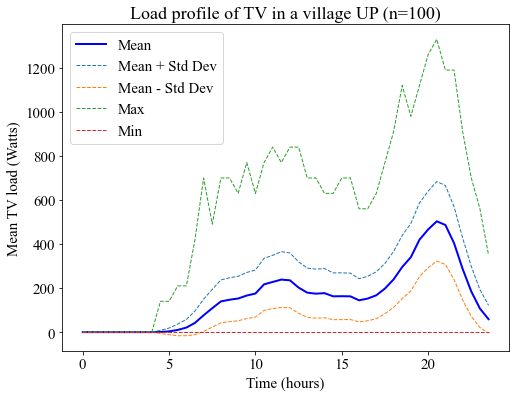

In [49]:
plt.figure(figsize=(8, 6))

plt.plot(np.arange(0, 24, time_step), mean_values, label='Mean', linewidth=2, linestyle= 'solid', color='blue')
plt.plot(np.arange(0, 24, time_step), mean_values + std_values, label='Mean + Std Dev', linestyle='--', linewidth=1)
plt.plot(np.arange(0, 24, time_step), mean_values - std_values, label='Mean - Std Dev', linestyle='--', linewidth=1)
plt.plot(np.arange(0, 24, time_step), max_values, label='Max', linestyle='--', linewidth=1)
plt.plot(np.arange(0, 24, time_step), min_values, label='Min', linestyle='--', linewidth=1)

plt.xlabel("Time (hours)")
plt.ylabel("Mean TV load (Watts)")
plt.title("Load profile of TV in a village UP (n=100)")



plt.legend()

plt.savefig('UP_TV_load_profile_simulation.png', dpi=300)


plt.show()

In [56]:
k = 3 #Laundry

def interpolate_start_probability(act,t):
    return start_times_interpolate_fn[act](t)

def generate_load_profile(n_paths=10000, duration_pdfs=None, time_zones=None, time_step=0.5 , act = 5):
    
    all_paths = [0 for i in range(n_paths)]
    if duration_pdfs is None:
        duration_pdfs = [["gaussian"] * 4]  # Default to Gaussian for all time zones

    if time_zones is None:
        time_zones = [4, 10, 16, 20]  # Default time zone boundaries

    time_steps = int(24 / time_step)
    
    def get_duration_pdf(t, duration_pdfs, time_zones):
        for i, zone_boundary in enumerate(time_zones):
            if t < zone_boundary:
                zone_idx = i
                break
        else:
            zone_idx = len(time_zones) - 1

        pdf_name, params = duration_pdfs[zone_idx]
        if pdf_name == "gaussian":
            return stats.norm(*params)
        elif pdf_name == "weibull_min":
            return stats.weibull_min(*params)
        else:
            raise ValueError("Invalid duration_pdf")

    mean_path = np.zeros(time_steps)
    
    for i in range(n_paths):
        path = np.zeros(time_steps)
        t = 0
        while t < time_steps:
            start_prob = interpolate_start_probability(act,t * time_step)
            if(start_prob  >0 and start_prob < 1):
                startstate = np.random.choice([0,1], p=[1-start_prob, start_prob]) #Binomial sampling
            else:
                startstate = 0
            if startstate == 1:
                dist = get_duration_pdf(t * time_step, duration_pdfs, time_zones)
                duration = int(dist.rvs() / time_step) #Duration sampling 
                if duration < 0:
                    duration = 0
                path[t:t+duration] =  1
                t += duration
            else:
                t += 1
        mean_path += path
        all_paths[i] = path
    mean_path /= n_paths
    return mean_path,all_paths

    
# Define the duration parameters for each time zone
duration_pdfs = [
    ("weibull_min", duration_weibull_parameters[0][k]),
    ("weibull_min", duration_weibull_parameters[1][k]),
    ("gaussian", duration_normal_parameters[2][k]),
    ("gaussian", duration_normal_parameters[3][k])
]

# Specify the time zone 
time_zones = [4, 10, 16, 20] # 4am - 10am Morning 10am -16pm afternoon 16pm - 20pm evening, 20pm-4am night. 


time_step = 0.5 # 30min
n_paths = 10000
mean_path,all_paths = generate_load_profile(n_paths =n_paths, duration_pdfs=duration_pdfs, time_zones=time_zones, time_step=time_step, act = k)



In [57]:
time_steps = int(24 / time_step)
load_per_washing = 220
no_of_machines = 100
no_of_subsampling = 5000
all_subsample_paths = [0 for i in range(no_of_subsampling)]
for j in range(no_of_subsampling):
    subsample_path_id = [np.random.choice(np.arange(0,n_paths,1)) for i in range(no_of_machines)]
    xtotal = np.zeros(time_steps)
    for i in subsample_path_id:
        xtotal += all_paths[i]*load_per_washing
    all_subsample_paths[j] = xtotal
all_subsample_paths = np.array(all_subsample_paths)

mean_values = np.mean(all_subsample_paths, axis=0)    
std_values = np.std(all_subsample_paths, axis=0)
max_values = np.max(all_subsample_paths, axis=0)
min_values = np.min(all_subsample_paths, axis=0)

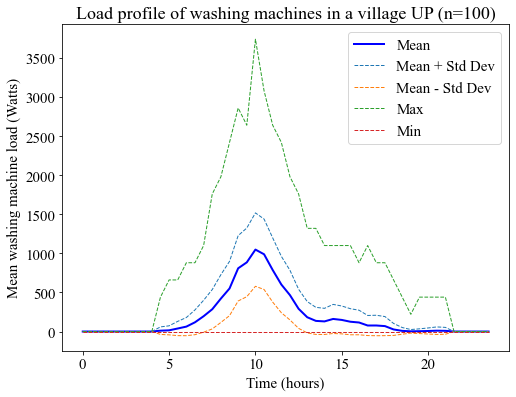

In [59]:
plt.figure(figsize=(8, 6))

plt.plot(np.arange(0, 24, time_step), mean_values, label='Mean', linewidth=2, color='blue')
plt.plot(np.arange(0, 24, time_step), mean_values + std_values, label='Mean + Std Dev', linestyle='--', linewidth=1)
plt.plot(np.arange(0, 24, time_step), mean_values - std_values, label='Mean - Std Dev', linestyle='--', linewidth=1)
plt.plot(np.arange(0, 24, time_step), max_values, label='Max', linestyle='--', linewidth=1)
plt.plot(np.arange(0, 24, time_step), min_values, label='Min', linestyle='--', linewidth=1)

plt.xlabel("Time (hours)")
plt.ylabel("Mean washing machine load (Watts)")
plt.title("Load profile of washing machines in a village UP (n=100)")

plt.legend()

plt.savefig('UP_washing_machine_load_profile.png', dpi=300)

plt.show()
